In [2]:
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import cv2
import time
import pandas as pd
import torchvision
import torch
import torchvision.transforms as transforms
import sys


import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from tqdm import tqdm_notebook , tnrange

import torch.utils.model_zoo as model_zoo
import torchvision.models as models
from torchvision import datasets
from tqdm.notebook import *
from torchcontrib.optim import SWA

import time
import matplotlib.pyplot as plt

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.43216, 0.394666, 0.37645],
                            std=[0.22803, 0.22145, 0.216989])
])
trans1 = transforms.ToPILImage()

In [3]:
import math
import torch
import torch.nn as nn
import util

from models.layers.penet import *


class PENetClassifier(nn.Module):
    """PENet stripped down for classification.

    The idea is to pre-train this network, then use the pre-trained
    weights for the encoder in a full PENet.
    """

    def __init__(self, model_depth, cardinality=32, num_channels=3, num_classes=600, init_method=None, **kwargs):
        super(PENetClassifier, self).__init__()

        self.in_channels = 64
        self.model_depth = model_depth
        self.cardinality = cardinality
        self.num_channels = num_channels
        self.num_classes = num_classes

        self.in_conv = nn.Sequential(nn.Conv3d(self.num_channels, self.in_channels, kernel_size=7,
                                               stride=(1, 2, 2), padding=(3, 3, 3), bias=False),
                                     nn.GroupNorm(self.in_channels // 16, self.in_channels),
                                     nn.LeakyReLU(inplace=True))
        self.max_pool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)

        # Encoders
        if model_depth != 50:
            raise ValueError('Unsupported model depth: {}'.format(model_depth))
        encoder_config = [3, 4, 6, 3]
        total_blocks = sum(encoder_config)
        block_idx = 0

        self.encoders = nn.ModuleList()
        for i, num_blocks in enumerate(encoder_config):
            out_channels = 2 ** i * 128
            stride = 1 if i == 0 else 2
            encoder = PENetEncoder(self.in_channels, out_channels, num_blocks, self.cardinality,
                                  block_idx, total_blocks, stride=stride)
            self.encoders.append(encoder)
            self.in_channels = out_channels * PENetBottleneck.expansion
            block_idx += num_blocks

        self.classifier = GAPLinear(self.in_channels, num_classes)

        if init_method is not None:
            self._initialize_weights(init_method, focal_pi=0.01)

    def _initialize_weights(self, init_method, gain=0.2, focal_pi=None):
        """Initialize all weights in the network."""
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d) or isinstance(m, nn.Linear):
                if init_method == 'normal':
                    nn.init.normal_(m.weight, mean=0, std=gain)
                elif init_method == 'xavier':
                    nn.init.xavier_normal_(m.weight, gain=gain)
                elif init_method == 'kaiming':
                    nn.init.kaiming_normal_(m.weight)
                else:
                    raise NotImplementedError('Invalid initialization method: {}'.format(self.init_method))
                if hasattr(m, 'bias') and m.bias is not None:
                    if focal_pi is not None and hasattr(m, 'is_output_head') and m.is_output_head:
                        # Focal loss prior (~0.01 prob for positive, see RetinaNet Section 4.1)
                        nn.init.constant_(m.bias, -math.log((1 - focal_pi) / focal_pi))
                    else:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.GroupNorm) and m.affine:
                # Gamma for last GroupNorm in each residual block gets set to 0
                init_gamma = 0 if hasattr(m, 'is_last_norm') and m.is_last_norm else 1
                nn.init.constant_(m.weight, init_gamma)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):

        # Expand input (allows pre-training on RGB videos, fine-tuning on Hounsfield Units)
        if x.size(1) < self.num_channels:
            x = x.expand(-1, self.num_channels // x.size(1), -1, -1, -1)

        x = self.in_conv(x)
        x = self.max_pool(x)

        # Encoders
        for encoder in self.encoders:
            x = encoder(x)

        # Classifier
        x = self.classifier(x)

        return x

    def args_dict(self):
        """Get a dictionary of args that can be used to reconstruct this architecture.
        To use the returned dict, initialize the model with `PENet(**model_args)`.
        """
        model_args = {
            'model_depth': self.model_depth,
            'cardinality': self.cardinality,
            'num_classes': self.num_classes,
            'num_channels': self.num_channels
        }

        return model_args

    def load_pretrained(self, ckpt_path, gpu_ids):
        """Load parameters from a pre-trained PENetClassifier from checkpoint at ckpt_path.
        Args:
            ckpt_path: Path to checkpoint for PENetClassifier.
        Adapted from:
            https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113/2
        """
        device = 'cuda:{}'.format(gpu_ids[0]) if len(gpu_ids) > 0 else 'cpu'
        pretrained_dict = torch.load(ckpt_path, map_location=device)['model_state']
        model_dict = self.state_dict()

        # Filter out unnecessary keys
        pretrained_dict = {k[len('module.'):]: v for k, v in pretrained_dict.items()}
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

        # Overwrite entries in the existing state dict
        model_dict.update(pretrained_dict)

        # Load the new state dict
        self.load_state_dict(model_dict)

    def fine_tuning_parameters(self, fine_tuning_boundary, fine_tuning_lr=0.0):
        """Get parameters for fine-tuning the model.
        Args:
            fine_tuning_boundary: Name of first layer after the fine-tuning layers.
            fine_tuning_lr: Learning rate to apply to fine-tuning layers (all layers before `boundary_layer`).
        Returns:
            List of dicts that can be passed to an optimizer.
        """

        def gen_params(boundary_layer_name, fine_tuning):
            """Generate parameters, if fine_tuning generate the params before boundary_layer_name.
            If unfrozen, generate the params at boundary_layer_name and beyond."""
            saw_boundary_layer = False
            for name, param in self.named_parameters():
                if name.startswith(boundary_layer_name):
                    saw_boundary_layer = True

                if saw_boundary_layer and fine_tuning:
                    return
                elif not saw_boundary_layer and not fine_tuning:
                    continue
                else:
                    yield param

        # Fine-tune the network's layers from encoder.2 onwards
        optimizer_parameters = [{'params': gen_params(fine_tuning_boundary, fine_tuning=True), 'lr': fine_tuning_lr},
                                {'params': gen_params(fine_tuning_boundary, fine_tuning=False)}]

        # Debugging info
        util.print_err('Number of fine-tuning layers: {}'
                       .format(sum(1 for _ in gen_params(fine_tuning_boundary, fine_tuning=True))))
        util.print_err('Number of regular layers: {}'
                       .format(sum(1 for _ in gen_params(fine_tuning_boundary, fine_tuning=False))))

        return optimizer_parameters

In [4]:
def form_batch(inpt_slices, outpt_size, size, augment):
    inpt_slices.sort_values(['path'], inplace = True)
    transform = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.43216, 0.394666, 0.37645],
                                        std=[0.22803, 0.22145, 0.216989])
                ])
    outpt = torch.zeros((3, outpt_size, size[0], size[1]))
    rot = (np.random.random()*2-1)*15
    c = int((np.random.random()*2-1)*size[0]*0.15)
    f = int((np.random.random()*2-1)*size[1]*0.15)
    for i, idx in enumerate(inpt_slices.index):
        im = Image.open(inpt_slices['path'][idx])
        if augment:
            im = im.rotate(rot, translate = (c,f))
        im_vect = transform(im)
        outpt[0][i] = im_vect[0]
        outpt[1][i] = im_vect[1]
        outpt[2][i] = im_vect[2]
    return(outpt)

In [5]:
class PE_dataset(torch.utils.data.Dataset):
    def __init__(self, Table, randomize = True, augment = True, window = 24):
        self.slices = list(Table['slice'].unique())
        self.window = window
        self.Table = Table
        self.augmented = augment
        if randomize:
            np.random.shuffle(self.slices)
    def __getitem__(self, index):
        mini_batch = self.Table[self.Table.slice == self.slices[index]].reset_index().drop(['index'], axis = 1)
        Study = mini_batch['StudyInstanceUID'][0]
        temp = self.Table[self.Table.StudyInstanceUID == Study]
        Input = form_batch(mini_batch, self.window, (256, 256), self.augmented)
        #Target = torch.zeros(2)
        Target = torch.zeros(5)
        pe_num = len(mini_batch[mini_batch.pe_present_on_image == 1])
        Target[0] = int(pe_num > (len(mini_batch) / 10))
        if pe_num > (len(mini_batch) / 8):
            Target[1] = mini_batch['central_pe'][0]
            Target[2] = mini_batch['rightsided_pe'][0]
            Target[3] = mini_batch['leftsided_pe'][0]
            Target[4] = mini_batch['chronic_pe'][0] + 2*mini_batch['acute_and_chronic_pe'][0]
        return([Input, Target])
    def __len__(self):
        return(len(self.slices))

In [6]:
import torch.nn.functional as F

def linear_combination(x, y, epsilon): 
    return epsilon*x + (1-epsilon)*y

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon:float=0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction
    
    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss/n, nll, self.epsilon)

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        crit = nn.BCELoss()
        BCE_loss = crit(inputs, targets) + 1e-7
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [8]:
def train(net, optimizer, train_loader, criterion1, criterion2, alpha = 1, beta = 1,  n_epoch = 2,
          train_acc_period = 5, classe = 2,
          test_acc_period = 5, detection = False,
          cuda=True, visualize = True, scheduler = None):
    loss_train = []
    loss_test = []
    total = 0
    if cuda:
        net = net.cuda()
        %env CUDA_LAUNCH_BLOCKING=1
    for epoch in tnrange(n_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        if scheduler != None:
            print(scheduler.get_last_lr())
        for i, (inputs, labels) in tqdm(enumerate(train_loader)):
            # get the inputs
            if cuda:
                net = net.cuda()
                inputs = inputs.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            #outputs = outputs.clamp(min = 0, max = 1)
            predicted = (outputs>0.5).float()
            if detection:
                #loss = 0.2*criterion1(outputs[:,0].float(), labels[:,0].float())
                loss = criterion1(outputs.float(), labels[:,classe])
            else:
                loss = criterion1(outputs[:,0].float(), labels[:,0].float())
                loss += alpha*criterion1(outputs[:,1:4].float(), labels[:,1:4].float())
                loss += beta*criterion2(outputs[:, 4:].float(), labels[:,4])
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            # print statistics
            running_loss = 0.33*loss.item()/labels.size(0) + 0.66*running_loss
            if detection:
                #correct = float((labels[:, 0] == predicted[:, 0]).sum())
                #correct = float(torch.logical_and((labels[:, classe] == predicted[:, 1]), labels[:, classe] == 1).sum())
                #if float((labels[:, classe] == 1).sum()) != 0:
                #    correct /= float((labels[:, classe] == 1).sum())
                _, pred = torch.max(outputs.data, 1)
                correct = float((pred == labels[:, classe]).sum())/labels.size(0)
                #print(pred)
                #print(labels[:, classe])
                #print(outputs.float(), labels.float())
                #print(correct)
                #if i ==10:
                #    ok
            else:
                correct = float((labels[:, 0] == predicted[:, 0]).sum())
                correct += alpha*float((labels[:, 1:4] == predicted[:, 1:4]).sum())
                correct += beta*float((torch.argmax(outputs[:, 4:]) == labels[:, 4]).sum())
                correct /= (1+ alpha*3 + beta)*labels.size(0)
            running_acc = 0.3*correct + 0.66*running_acc
            loss_train.append(running_loss)
            if visualize:
                if i % train_acc_period == train_acc_period-1:
                    #print(labels[:, classe] == 1)
                    #print(predicted[:, 1] == 1)
                    #print('TP: ', torch.logical_and((labels[:, classe] == predicted[:, 1]), labels[:, classe] == 1))
                    print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
                    print('[%d, %5d] acc: %.3f' %(epoch + 1, i + 1, running_acc))
                    running_loss = 0.0
                    total = 0
            inputs = None
            outputs = None
            labels = None
            predicted = None
        if scheduler != None:
            scheduler.step()
      
    if visualize:
        print('Finished Training')
    return(loss_train[-1])

In [9]:
def TP(predicted, labels):
    return(torch.logical_and((predicted == labels) , (labels == 1)).sum().item())
def TN(predicted, labels):
    return(torch.logical_and((predicted == labels) , (labels == 0)).sum().item())
def FP(predicted, labels):
    return(torch.logical_and((predicted != labels) , (labels == 1)).sum().item())
def FN(predicted, labels):
    return(torch.logical_and((predicted != labels) , (labels == 0)).sum().item())
def Fscore(TP, FP, TN, FN):
    precision = TP/(TP + FP + 0.0001)
    recall = TP/(TP + FN + 0.0001)
    return(precision, recall, 2*precision*recall/(precision + recall + 0.0001))

def evaluate(net, test_loader):
    total = 0
    correct = 0
    net.eval()
    net.cuda()
    tp = [0, 0, 0, 0]
    tn = [0, 0, 0, 0]
    fp = [0, 0, 0, 0]
    fn = [0, 0, 0, 0]
    for i, (inputs, target) in tqdm(enumerate(test_loader)):
        inputs = inputs.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        outputs = net(inputs)
        #print(outputs, target)
        #if i == 4:
        #    ok
        predicted = (outputs>0.5).float()
        detection = predicted[:, 0]
        location1 = predicted[:, 1]
        location2 = predicted[:, 2]
        location3 = predicted[:, 3]
        tp[0] += TP(detection, target[:, 0])
        tp[1] += TP(location1, target[:, 1])
        tp[2] += TP(location2, target[:, 2])
        tp[3] += TP(location3, target[:, 3])
        tn[0] += TN(detection, target[:, 0])
        tn[1] += TN(location1, target[:, 1])
        tn[2] += TN(location2, target[:, 2])
        tn[3] += TN(location3, target[:, 3])
        fp[0] += FP(detection, target[:, 0])
        fp[1] += FP(location1, target[:, 1])
        fp[2] += FP(location2, target[:, 2])
        fp[3] += FP(location3, target[:, 3])
        fn[0] += FN(detection, target[:, 0])
        fn[1] += FN(location1, target[:, 1])
        fn[2] += FN(location2, target[:, 2])
        fn[3] += FN(location3, target[:, 3])
        
        _, chronic = torch.max(outputs[: , 4:].data, 1)
        total += target.size(0)
        correct += (chronic == target[:, 4]).sum().item()
        
    net.train()
    f0 = Fscore(tp[0], fp[0], tn[0], fn[0])
    f1 = Fscore(tp[1], fp[1], tn[1], fn[1])
    f2 = Fscore(tp[2], fp[2], tn[2], fn[2])
    f3 = Fscore(tp[3], fp[3], tn[3], fn[3])
    acc = float(correct)/total #81% base
    print(tp[0], tn[0], fp[0], fn[0])
    print(tp[1], tn[1], fp[1], fn[1])
    print(tp[2], tn[2], fp[2], fn[2])
    print(tp[3], tn[3], fp[3], fn[3])
    print(correct, total)
    return(f0, f1, f2, f3, acc)

def evaluate_per_class(net, test_loader, classe):
    total = 0
    correct = 0
    net.eval()
    net.cuda()
    tp = [0, 0]
    tn = [0, 0]
    fp = [0, 0]
    fn = [0, 0]
    for i, (inputs, target) in tqdm(enumerate(test_loader)):
        inputs = inputs.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        outputs = net(inputs)
        #print(outputs, target)
        #if i == 4:
        #    ok

        predicted = (outputs>0.5).float()
        detection = predicted[:, 0]
        location1 = predicted[:, 1]
        tp[0] += TP(detection, target[:, 0])
        tn[0] += TN(detection, target[:, 0])
        fp[0] += FP(detection, target[:, 0])
        fn[0] += FN(detection, target[:, 0])
        
        if classe != 4:
            tp[1] += TP(location1, target[:, classe])
            tn[1] += TN(location1, target[:, classe])
            fp[1] += FP(location1, target[:, classe])
            fn[1] += FN(location1, target[:, classe])
        else:
            _, chronic = torch.max(outputs[: , 1:].data, 1)
            total += target.size(0)
            correct += (chronic == target[:, classe]).sum().item()
        
    net.train()
    f0 = Fscore(tp[0], fp[0], tn[0], fn[0])
    print(tp[0], tn[0], fp[0], fn[0])
    if classe != 4:
        f1 = Fscore(tp[1], fp[1], tn[1], fn[1])
        print(tp[1], tn[1], fp[1], fn[1])
    else:
        f1 = float(correct)/total #81% base
        print(correct, total)
    return(f0, f1)

def evaluate_per_class_CRE(net, test_loader, classe):
    total = 0
    correct = 0
    net.eval()
    net.cuda()
    for i, (inputs, target) in tqdm(enumerate(test_loader)):
        inputs = inputs.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        outputs = net(inputs)
        print(outputs, target)
        if i == 4:
            ok
        
        _, chronic = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (chronic == target[:, classe]).sum().item()
        
    net.train()
    f1 = float(correct)/total #81% base
    print(correct, total)
    return(f0, f1)

In [10]:
def peNet(num_classes):
    net = PENetClassifier(50, num_classes = 1)
    net = nn.DataParallel(net)
    net.load_state_dict(torch.load('penet.pth'))
    net.module.classifier.fc = nn.Linear(2048, num_classes)
    return(net)

In [11]:
tab = pd.read_csv('/media/aous/Samsung_T5/mtrain_sliced_48.csv')
repart = list(tab['StudyInstanceUID'].unique())
test_exams = repart[:1000]
train_exams = repart[1000:]
traindf = tab[tab['StudyInstanceUID'].isin(train_exams)]
testdf = tab[tab['StudyInstanceUID'].isin(test_exams)]

In [12]:
def weighted_dataset(train_dataset, size, Positives):
    p_num = int(size*Positives)
    n_num = size - p_num
    P = train_dataset[train_dataset.pe_present_on_image == 1].reset_index()
    P = P.drop(['index'], axis =1)
    N = train_dataset[train_dataset.pe_present_on_image == 0].reset_index()
    N = N.drop(['index'], axis =1)
    LP = list(P['slice'].unique())
    LN = list(N['slice'].unique())
    np.random.shuffle(LP)
    np.random.shuffle(LN)
    LP = LP[:p_num]
    LN = LN[:n_num]
    print(len(LP), len(LN))
    train_dataset_balanced = pd.concat([P[P.slice.isin(LP)], N[N.slice.isin(LN)]])
    train_dataset_balanced = train_dataset_balanced.sort_values(by=['SOPInstanceUID']).reset_index()
    train_dataset_balanced = train_dataset_balanced.drop(['index'], axis =1)
    return(train_dataset_balanced)

In [12]:
L = list(traindf[traindf.central_pe == 1][traindf.acute_and_chronic_pe == 1]['StudyInstanceUID'].unique())
L += list(traindf[traindf.rightsided_pe == 1][traindf.acute_and_chronic_pe == 1]['StudyInstanceUID'].unique())[:40]
L += list(traindf[traindf.leftsided_pe == 1][traindf.acute_and_chronic_pe == 1]['StudyInstanceUID'].unique())[:40]
L += list(traindf[traindf.leftsided_pe == 1][traindf.chronic_pe == 1]['StudyInstanceUID'].unique())[:40]
L += list(traindf[traindf.rightsided_pe == 1][traindf.chronic_pe == 1]['StudyInstanceUID'].unique())[:40]
L += list(traindf[traindf.central_pe == 1][traindf.chronic_pe == 1]['StudyInstanceUID'].unique())[:40]
L += list(traindf[traindf.leftsided_pe == 1][traindf.acute_and_chronic_pe == 0][traindf.chronic_pe == 0]['StudyInstanceUID'].unique())[:40]
L += list(traindf[traindf.rightsided_pe == 1][traindf.acute_and_chronic_pe == 0][traindf.chronic_pe == 0]['StudyInstanceUID'].unique())[:40]
L += list(traindf[traindf.central_pe == 1][traindf.acute_and_chronic_pe == 0][traindf.chronic_pe == 0]['StudyInstanceUID'].unique())[:40]
Negative_Exams = traindf[traindf.negative_exam_for_pe == 1]['StudyInstanceUID'].unique()
np.random.shuffle(Negative_Exams)
L += list(Negative_Exams)[:345]
np.random.shuffle(L)
Balanced_traindf = traindf[traindf.StudyInstanceUID.isin(L)].reset_index().drop(['index'], axis = 1)

/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_laun

In [13]:
train_dataset = PE_dataset(weighted_dataset(traindf, 7000, 0.5), augment = True, window = 48)
test_dataset = PE_dataset(testdf, augment = False, window = 48)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, num_workers = 4)

net = peNet(7)
#criterion1 = FocalLoss(alpha = 3, gamma = 2)
criterion1 = nn.BCELoss()
criterion2 = nn.CrossEntropyLoss()
#criterion2 = LabelSmoothingCrossEntropy(0.1)

learning_rate = 1e-4
#net = nn.DataParallel(net)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.9, dampening=0.9, weight_decay=1e-3) 
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 2, T_mult=2, eta_min=0, last_epoch=-1)
train(net, optimizer, train_loader, criterion1, criterion2, alpha = 1,  n_epoch = 2, visualize =True,
                  cuda = True,  train_acc_period = 50, scheduler = None, detection = True)
result = evaluate(net, test_loader)

3500 3500
env: CUDA_LAUNCH_BLOCKING=1


[1,    50] loss: 9.352
[1,    50] acc: 0.542
[1,   100] loss: 8.920
[1,   100] acc: 0.558
[1,   150] loss: 3.028
[1,   150] acc: 0.345
[1,   200] loss: 0.162
[1,   200] acc: 0.406
[1,   250] loss: 0.162
[1,   250] acc: 0.533
[1,   300] loss: 0.152
[1,   300] acc: 0.592
[1,   350] loss: 0.165
[1,   350] acc: 0.492
[1,   400] loss: 0.149
[1,   400] acc: 0.734
[1,   450] loss: 0.150
[1,   450] acc: 0.680
[1,   500] loss: 0.154
[1,   500] acc: 0.686
[1,   550] loss: 0.145
[1,   550] acc: 0.703
[1,   600] loss: 0.121
[1,   600] acc: 0.784
[1,   650] loss: 0.152
[1,   650] acc: 0.681
[1,   700] loss: 0.131
[1,   700] acc: 0.653
[1,   750] loss: 0.166
[1,   750] acc: 0.502
[1,   800] loss: 0.115
[1,   800] acc: 0.710
[1,   850] loss: 0.154
[1,   850] acc: 0.553
[1,   900] loss: 0.152
[1,   900] acc: 0.619
[1,   950] loss: 0.122
[1,   950] acc: 0.725
[1,  1000] loss: 0.117
[1,  1000] acc: 0.705
[1,  1050] loss: 0.135
[1,  1050] acc: 0.634
[1,  1100] loss: 0.123
[1,  1100] acc: 0.694
[1,  1150]

[2,    50] loss: 0.114
[2,    50] acc: 0.691
[2,   100] loss: 0.107
[2,   100] acc: 0.702
[2,   150] loss: 0.112
[2,   150] acc: 0.650
[2,   200] loss: 0.084
[2,   200] acc: 0.749
[2,   250] loss: 0.116
[2,   250] acc: 0.599
[2,   300] loss: 0.094
[2,   300] acc: 0.649
[2,   350] loss: 0.116
[2,   350] acc: 0.585
[2,   400] loss: 0.071
[2,   400] acc: 0.777
[2,   450] loss: 0.070
[2,   450] acc: 0.805
[2,   500] loss: 0.094
[2,   500] acc: 0.618
[2,   550] loss: 0.059
[2,   550] acc: 0.727
[2,   600] loss: 0.081
[2,   600] acc: 0.739
[2,   650] loss: 0.080
[2,   650] acc: 0.823
[2,   700] loss: 0.058
[2,   700] acc: 0.805
[2,   750] loss: 0.081
[2,   750] acc: 0.854
[2,   800] loss: 0.061
[2,   800] acc: 0.845
[2,   850] loss: 0.081
[2,   850] acc: 0.790
[2,   900] loss: 0.121
[2,   900] acc: 0.704
[2,   950] loss: 0.041
[2,   950] acc: 0.825
[2,  1000] loss: 0.085
[2,  1000] acc: 0.719
[2,  1050] loss: 0.085
[2,  1050] acc: 0.695
[2,  1100] loss: 0.058
[2,  1100] acc: 0.801
[2,  1150]


17 4858


In [36]:
L = list(traindf[traindf.central_pe == 1]['StudyInstanceUID'].unique())
L += list(traindf[traindf.negative_exam_for_pe == 0][traindf.central_pe == 0]['StudyInstanceUID'].unique())[:341]
Negative_Exams = traindf[traindf.negative_exam_for_pe == 1]['StudyInstanceUID'].unique()
np.random.shuffle(Negative_Exams)
L += list(Negative_Exams)[:650]
np.random.shuffle(L)
new_traindf = traindf[traindf.StudyInstanceUID.isin(L)].reset_index().drop(['index'], axis = 1)
train_dataset = PE_dataset(new_traindf, augment = True, window = 48)
test_dataset = PE_dataset(testdf, augment = False, window = 48)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, num_workers = 4)

net = peNet(7)
net.load_state_dict(torch.load('PEnet_45.pth'))
#criterion1 = FocalLoss(alpha = 3, gamma = 2)
criterion1 = nn.BCELoss()
criterion2 = nn.CrossEntropyLoss()
#criterion2 = LabelSmoothingCrossEntropy(0.1)

learning_rate = 5e-5
#net = nn.DataParallel(net)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.9, dampening=0.9, weight_decay=1e-3) 
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 2, T_mult=2, eta_min=0, last_epoch=-1)
train(net, optimizer, train_loader, criterion1, criterion2, alpha = 1,  n_epoch = 2, visualize =True,
                  cuda = True,  train_acc_period = 50, scheduler = None, detection = True)
result = evaluate(net, test_loader)

/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


env: CUDA_LAUNCH_BLOCKING=1


[1,    50] loss: 0.102
[1,    50] acc: 0.741
[1,   100] loss: 0.061
[1,   100] acc: 0.828
[1,   150] loss: 0.053
[1,   150] acc: 0.793
[1,   200] loss: 0.047
[1,   200] acc: 0.820
[1,   250] loss: 0.055
[1,   250] acc: 0.805
[1,   300] loss: 0.031
[1,   300] acc: 0.835
[1,   350] loss: 0.062
[1,   350] acc: 0.765
[1,   400] loss: 0.068
[1,   400] acc: 0.790
[1,   450] loss: 0.053
[1,   450] acc: 0.778
[1,   500] loss: 0.050
[1,   500] acc: 0.789
[1,   550] loss: 0.090
[1,   550] acc: 0.742
[1,   600] loss: 0.061
[1,   600] acc: 0.785
[1,   650] loss: 0.087
[1,   650] acc: 0.734
[1,   700] loss: 0.059
[1,   700] acc: 0.808
[1,   750] loss: 0.064
[1,   750] acc: 0.754
[1,   800] loss: 0.089
[1,   800] acc: 0.754
[1,   850] loss: 0.074
[1,   850] acc: 0.778
[1,   900] loss: 0.077
[1,   900] acc: 0.755
[1,   950] loss: 0.054
[1,   950] acc: 0.781
[1,  1000] loss: 0.089
[1,  1000] acc: 0.768
[1,  1050] loss: 0.046
[1,  1050] acc: 0.832
[1,  1100] loss: 0.056
[1,  1100] acc: 0.803
[1,  1150]

[2,    50] loss: 0.094
[2,    50] acc: 0.730
[2,   100] loss: 0.051
[2,   100] acc: 0.832
[2,   150] loss: 0.054
[2,   150] acc: 0.793
[2,   200] loss: 0.049
[2,   200] acc: 0.817
[2,   250] loss: 0.065
[2,   250] acc: 0.810
[2,   300] loss: 0.027
[2,   300] acc: 0.835
[2,   350] loss: 0.053
[2,   350] acc: 0.803
[2,   400] loss: 0.063
[2,   400] acc: 0.791
[2,   450] loss: 0.051
[2,   450] acc: 0.813
[2,   500] loss: 0.045
[2,   500] acc: 0.797
[2,   550] loss: 0.062
[2,   550] acc: 0.773
[2,   600] loss: 0.040
[2,   600] acc: 0.823
[2,   650] loss: 0.071
[2,   650] acc: 0.760
[2,   700] loss: 0.057
[2,   700] acc: 0.808
[2,   750] loss: 0.067
[2,   750] acc: 0.732
[2,   800] loss: 0.108
[2,   800] acc: 0.749
[2,   850] loss: 0.062
[2,   850] acc: 0.796
[2,   900] loss: 0.061
[2,   900] acc: 0.740
[2,   950] loss: 0.057
[2,   950] acc: 0.792
[2,  1000] loss: 0.059
[2,  1000] acc: 0.792
[2,  1050] loss: 0.035
[2,  1050] acc: 0.825
[2,  1100] loss: 0.054
[2,  1100] acc: 0.803
[2,  1150]


230 4154 200 274
40 4697 68 53
0 4527 331 0
0 4561 297 0
17 4858


In [37]:
result

((0.5348835965386985, 0.4563491158037469, 0.492455566732158),
 (0.3703700274351598, 0.430107064401006, 0.39795983888796144),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 0.0),
 0.003499382461918485)

In [17]:
#torch.save(net.state_dict(), 'PEnet_49_40.pth')

In [30]:
classes['slice'].nunique()

35421

In [12]:
classes = pd.read_csv('/media/aous/Samsung_T5/classes.csv')
L = list(classes[classes.central_pe == 1]['slice'].unique())[:681]
L += list(classes[classes.rightsided_pe == 1]['slice'].unique())[:681]
L += list(classes[classes.PE == 1][classes.rightsided_pe == 0][classes.central_pe == 0]['slice'].unique())
Negative_Exams = classes[classes.PE == 0]['slice'].unique()
np.random.shuffle(Negative_Exams)
L += list(Negative_Exams)[:2043]
print(len(L))
np.random.shuffle(L)
new_traindf = traindf[traindf.slice.isin(L)].reset_index().drop(['index'], axis = 1)

4086


/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [49]:
train_classes[train_classes.PE == 1][train_classes.rightsided_pe == 0]['slice'].nunique()

/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


608

In [12]:
classes = pd.read_csv('/media/aous/Samsung_T5/classes.csv')
train_classes = classes[classes.slice.isin(traindf['slice'].unique())]
Num_max = 6000
perc = 0.5
#L = list(np.random.choice(train_classes[train_classes.central_pe == 1][train_classes.rightsided_pe == 0]['slice'].unique(), int((1-perc)*Num_max*1.5/5.0)))
#print(len(L), "central")
#L = list(np.random.choice(train_classes[train_classes.rightsided_pe == 1]['slice'].unique(), int((1-perc)*0.5*Num_max)))
#print(int((1-perc)*0.5*Num_max), "right")
#L += list(np.random.choice(train_classes[train_classes.rightsided_pe == 1][train_classes.central_pe == 1]['slice'].unique(), int((1-perc)*Num_max*1/5.0)))
#print(int((1-perc)*Num_max*1/5.0), "right/ central")
#L += list(np.random.choice(train_classes[train_classes.PE == 1][train_classes.rightsided_pe == 0][train_classes.central_pe == 0]['slice'].unique(), int((1-perc)*Num_max*1.5/5.0)))
#print(int((1-perc)*Num_max*1/5.0), "left only")
Negative_Exams = train_classes[train_classes.PE == 0]['slice'].unique()
np.random.shuffle(Negative_Exams)
L = list(np.random.choice(Negative_Exams, int(Num_max*perc)))
print(int(Num_max*perc), "negative")
Positive_Exams = train_classes[train_classes.PE == 1]['slice'].unique()
np.random.shuffle(Positive_Exams)
L += list(np.random.choice(Positive_Exams, int(Num_max*perc)))
print(len(L), "all")

np.random.shuffle(L)
new_traindf = traindf[traindf.slice.isin(L)].reset_index().drop(['index'], axis = 1)
train_dataset = PE_dataset(new_traindf, augment = True, window = 48)
test_dataset = PE_dataset(testdf, augment = False, window = 48)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, num_workers = 4)

criterion1 = FocalLoss(alpha = 1, gamma = 2)              
criterion2 = nn.CrossEntropyLoss()

net = peNet(2)
net.load_state_dict(torch.load('PE_50_2.pth'))
learning_rate = 1e-6
#net = nn.DataParallel(net)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.9, dampening=0.9, weight_decay=1e-3) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20, eta_min=0, last_epoch=-1)
train(net, optimizer, train_loader, criterion1, criterion2, alpha = 1,  n_epoch = 10, visualize =True,
                  cuda = True, classe = 2,  train_acc_period = 50, scheduler = scheduler, detection = True)
result = evaluate_per_class(net, test_loader, 1)

3000 negative
6000 all
env: CUDA_LAUNCH_BLOCKING=1


[1e-06]


[1,    50] loss: 0.020
[1,    50] acc: 0.651
[1,   100] loss: 0.019
[1,   100] acc: 0.635
[1,   150] loss: 0.020
[1,   150] acc: 0.781
[1,   200] loss: 0.007
[1,   200] acc: 0.807
[1,   250] loss: 0.014
[1,   250] acc: 0.686
[1,   300] loss: 0.025
[1,   300] acc: 0.572
[1,   350] loss: 0.025
[1,   350] acc: 0.618
[1,   400] loss: 0.023
[1,   400] acc: 0.602
[1,   450] loss: 0.025
[1,   450] acc: 0.700
[1,   500] loss: 0.026
[1,   500] acc: 0.575
[1,   550] loss: 0.008
[1,   550] acc: 0.736
[1,   600] loss: 0.022
[1,   600] acc: 0.656
[1,   650] loss: 0.021
[1,   650] acc: 0.668
[1,   700] loss: 0.017
[1,   700] acc: 0.637
[1,   750] loss: 0.010
[1,   750] acc: 0.731
[1,   800] loss: 0.018
[1,   800] acc: 0.659
[1,   850] loss: 0.018
[1,   850] acc: 0.682
[1,   900] loss: 0.020
[1,   900] acc: 0.605
[1,   950] loss: 0.015
[1,   950] acc: 0.767
[1,  1000] loss: 0.010
[1,  1000] acc: 0.754
[1,  1050] loss: 0.033
[1,  1050] acc: 0.475
[1,  1100] loss: 0.019
[1,  1100] acc: 0.605
[1,  1150]

[2,    50] loss: 0.023
[2,    50] acc: 0.652
[2,   100] loss: 0.018
[2,   100] acc: 0.695
[2,   150] loss: 0.021
[2,   150] acc: 0.730
[2,   200] loss: 0.006
[2,   200] acc: 0.825
[2,   250] loss: 0.016
[2,   250] acc: 0.627
[2,   300] loss: 0.029
[2,   300] acc: 0.534
[2,   350] loss: 0.021
[2,   350] acc: 0.689
[2,   400] loss: 0.026
[2,   400] acc: 0.590
[2,   450] loss: 0.025
[2,   450] acc: 0.665
[2,   500] loss: 0.026
[2,   500] acc: 0.569
[2,   550] loss: 0.007
[2,   550] acc: 0.740
[2,   600] loss: 0.022
[2,   600] acc: 0.658
[2,   650] loss: 0.021
[2,   650] acc: 0.637
[2,   700] loss: 0.017
[2,   700] acc: 0.636
[2,   750] loss: 0.009
[2,   750] acc: 0.731
[2,   800] loss: 0.012
[2,   800] acc: 0.665
[2,   850] loss: 0.016
[2,   850] acc: 0.725
[2,   900] loss: 0.022
[2,   900] acc: 0.617
[2,   950] loss: 0.016
[2,   950] acc: 0.716
[2,  1000] loss: 0.007
[2,  1000] acc: 0.757
[2,  1050] loss: 0.037
[2,  1050] acc: 0.497
[2,  1100] loss: 0.019
[2,  1100] acc: 0.615
[2,  1150]

[3,    50] loss: 0.025
[3,    50] acc: 0.635
[3,   100] loss: 0.018
[3,   100] acc: 0.752
[3,   150] loss: 0.026
[3,   150] acc: 0.617
[3,   200] loss: 0.008
[3,   200] acc: 0.789
[3,   250] loss: 0.015
[3,   250] acc: 0.675
[3,   300] loss: 0.027
[3,   300] acc: 0.572
[3,   350] loss: 0.027
[3,   350] acc: 0.665
[3,   400] loss: 0.022
[3,   400] acc: 0.718
[3,   450] loss: 0.027
[3,   450] acc: 0.527
[3,   500] loss: 0.027
[3,   500] acc: 0.584
[3,   550] loss: 0.008
[3,   550] acc: 0.734
[3,   600] loss: 0.024
[3,   600] acc: 0.660
[3,   650] loss: 0.021
[3,   650] acc: 0.700
[3,   700] loss: 0.019
[3,   700] acc: 0.648
[3,   750] loss: 0.012
[3,   750] acc: 0.659
[3,   800] loss: 0.014
[3,   800] acc: 0.730
[3,   850] loss: 0.018
[3,   850] acc: 0.744
[3,   900] loss: 0.018
[3,   900] acc: 0.642
[3,   950] loss: 0.016
[3,   950] acc: 0.712
[3,  1000] loss: 0.008
[3,  1000] acc: 0.764
[3,  1050] loss: 0.038
[3,  1050] acc: 0.496
[3,  1100] loss: 0.023
[3,  1100] acc: 0.614
[3,  1150]

[4,    50] loss: 0.021
[4,    50] acc: 0.636
[4,   100] loss: 0.017
[4,   100] acc: 0.668
[4,   150] loss: 0.027
[4,   150] acc: 0.572
[4,   200] loss: 0.009
[4,   200] acc: 0.755
[4,   250] loss: 0.015
[4,   250] acc: 0.673
[4,   300] loss: 0.025
[4,   300] acc: 0.566
[4,   350] loss: 0.024
[4,   350] acc: 0.699
[4,   400] loss: 0.022
[4,   400] acc: 0.706
[4,   450] loss: 0.026
[4,   450] acc: 0.666
[4,   500] loss: 0.024
[4,   500] acc: 0.613
[4,   550] loss: 0.007
[4,   550] acc: 0.733
[4,   600] loss: 0.026
[4,   600] acc: 0.627
[4,   650] loss: 0.020
[4,   650] acc: 0.689
[4,   700] loss: 0.024
[4,   700] acc: 0.575
[4,   750] loss: 0.010
[4,   750] acc: 0.703
[4,   800] loss: 0.012
[4,   800] acc: 0.658
[4,   850] loss: 0.019
[4,   850] acc: 0.717
[4,   900] loss: 0.020
[4,   900] acc: 0.582
[4,   950] loss: 0.033
[4,   950] acc: 0.542
[4,  1000] loss: 0.006
[4,  1000] acc: 0.756
[4,  1050] loss: 0.038
[4,  1050] acc: 0.506
[4,  1100] loss: 0.024
[4,  1100] acc: 0.640
[4,  1150]

[5,    50] loss: 0.021
[5,    50] acc: 0.659
[5,   100] loss: 0.017
[5,   100] acc: 0.629
[5,   150] loss: 0.022
[5,   150] acc: 0.619
[5,   200] loss: 0.009
[5,   200] acc: 0.807
[5,   250] loss: 0.016
[5,   250] acc: 0.670
[5,   300] loss: 0.028
[5,   300] acc: 0.576
[5,   350] loss: 0.027
[5,   350] acc: 0.659
[5,   400] loss: 0.021
[5,   400] acc: 0.699
[5,   450] loss: 0.026
[5,   450] acc: 0.616
[5,   500] loss: 0.025
[5,   500] acc: 0.516
[5,   550] loss: 0.006
[5,   550] acc: 0.739
[5,   600] loss: 0.024
[5,   600] acc: 0.670
[5,   650] loss: 0.023
[5,   650] acc: 0.614
[5,   700] loss: 0.018
[5,   700] acc: 0.670
[5,   750] loss: 0.009
[5,   750] acc: 0.714
[5,   800] loss: 0.011
[5,   800] acc: 0.786
[5,   850] loss: 0.016
[5,   850] acc: 0.723
[5,   900] loss: 0.016
[5,   900] acc: 0.637
[5,   950] loss: 0.015
[5,   950] acc: 0.716
[5,  1000] loss: 0.007
[5,  1000] acc: 0.764
[5,  1050] loss: 0.039
[5,  1050] acc: 0.475
[5,  1100] loss: 0.020
[5,  1100] acc: 0.646
[5,  1150]

[6,    50] loss: 0.019
[6,    50] acc: 0.651
[6,   100] loss: 0.016
[6,   100] acc: 0.759
[6,   150] loss: 0.026
[6,   150] acc: 0.545
[6,   200] loss: 0.006
[6,   200] acc: 0.812
[6,   250] loss: 0.014
[6,   250] acc: 0.661
[6,   300] loss: 0.022
[6,   300] acc: 0.555
[6,   350] loss: 0.022
[6,   350] acc: 0.742
[6,   400] loss: 0.021
[6,   400] acc: 0.686
[6,   450] loss: 0.024
[6,   450] acc: 0.626
[6,   500] loss: 0.026
[6,   500] acc: 0.668
[6,   550] loss: 0.007
[6,   550] acc: 0.734
[6,   600] loss: 0.023
[6,   600] acc: 0.657
[6,   650] loss: 0.022
[6,   650] acc: 0.635
[6,   700] loss: 0.016
[6,   700] acc: 0.719
[6,   750] loss: 0.009
[6,   750] acc: 0.737
[6,   800] loss: 0.014
[6,   800] acc: 0.660
[6,   850] loss: 0.020
[6,   850] acc: 0.659
[6,   900] loss: 0.017
[6,   900] acc: 0.674
[6,   950] loss: 0.025
[6,   950] acc: 0.685
[6,  1000] loss: 0.006
[6,  1000] acc: 0.763
[6,  1050] loss: 0.039
[6,  1050] acc: 0.506
[6,  1100] loss: 0.016
[6,  1100] acc: 0.599
[6,  1150]

[7,    50] loss: 0.024
[7,    50] acc: 0.656
[7,   100] loss: 0.017
[7,   100] acc: 0.734
[7,   150] loss: 0.024
[7,   150] acc: 0.546
[7,   200] loss: 0.006
[7,   200] acc: 0.826
[7,   250] loss: 0.016
[7,   250] acc: 0.628
[7,   300] loss: 0.024
[7,   300] acc: 0.543
[7,   350] loss: 0.020
[7,   350] acc: 0.661
[7,   400] loss: 0.025
[7,   400] acc: 0.626
[7,   450] loss: 0.029
[7,   450] acc: 0.452
[7,   500] loss: 0.024
[7,   500] acc: 0.567
[7,   550] loss: 0.007
[7,   550] acc: 0.690
[7,   600] loss: 0.023
[7,   600] acc: 0.661
[7,   650] loss: 0.022
[7,   650] acc: 0.643
[7,   700] loss: 0.015
[7,   700] acc: 0.634
[7,   750] loss: 0.008
[7,   750] acc: 0.723
[7,   800] loss: 0.015
[7,   800] acc: 0.667
[7,   850] loss: 0.019
[7,   850] acc: 0.729
[7,   900] loss: 0.017
[7,   900] acc: 0.635
[7,   950] loss: 0.015
[7,   950] acc: 0.765
[7,  1000] loss: 0.006
[7,  1000] acc: 0.754
[7,  1050] loss: 0.039
[7,  1050] acc: 0.506
[7,  1100] loss: 0.018
[7,  1100] acc: 0.609
[7,  1150]

[8,    50] loss: 0.019
[8,    50] acc: 0.670
[8,   100] loss: 0.016
[8,   100] acc: 0.679
[8,   150] loss: 0.024
[8,   150] acc: 0.551
[8,   200] loss: 0.006
[8,   200] acc: 0.805
[8,   250] loss: 0.014
[8,   250] acc: 0.667
[8,   300] loss: 0.024
[8,   300] acc: 0.598
[8,   350] loss: 0.023
[8,   350] acc: 0.618
[8,   400] loss: 0.023
[8,   400] acc: 0.627
[8,   450] loss: 0.025
[8,   450] acc: 0.619
[8,   500] loss: 0.025
[8,   500] acc: 0.494
[8,   550] loss: 0.008
[8,   550] acc: 0.734
[8,   600] loss: 0.024
[8,   600] acc: 0.585
[8,   650] loss: 0.023
[8,   650] acc: 0.635
[8,   700] loss: 0.015
[8,   700] acc: 0.720
[8,   750] loss: 0.012
[8,   750] acc: 0.687
[8,   800] loss: 0.013
[8,   800] acc: 0.709
[8,   850] loss: 0.017
[8,   850] acc: 0.618
[8,   900] loss: 0.017
[8,   900] acc: 0.629
[8,   950] loss: 0.015
[8,   950] acc: 0.767
[8,  1000] loss: 0.011
[8,  1000] acc: 0.775
[8,  1050] loss: 0.033
[8,  1050] acc: 0.497
[8,  1100] loss: 0.017
[8,  1100] acc: 0.646
[8,  1150]

[9,    50] loss: 0.021
[9,    50] acc: 0.703
[9,   100] loss: 0.014
[9,   100] acc: 0.733
[9,   150] loss: 0.026
[9,   150] acc: 0.574
[9,   200] loss: 0.009
[9,   200] acc: 0.740
[9,   250] loss: 0.015
[9,   250] acc: 0.714
[9,   300] loss: 0.030
[9,   300] acc: 0.576
[9,   350] loss: 0.021
[9,   350] acc: 0.742
[9,   400] loss: 0.019
[9,   400] acc: 0.683
[9,   450] loss: 0.030
[9,   450] acc: 0.542
[9,   500] loss: 0.024
[9,   500] acc: 0.597
[9,   550] loss: 0.008
[9,   550] acc: 0.765
[9,   600] loss: 0.025
[9,   600] acc: 0.672
[9,   650] loss: 0.018
[9,   650] acc: 0.704
[9,   700] loss: 0.019
[9,   700] acc: 0.703
[9,   750] loss: 0.009
[9,   750] acc: 0.731
[9,   800] loss: 0.015
[9,   800] acc: 0.704
[9,   850] loss: 0.020
[9,   850] acc: 0.620
[9,   900] loss: 0.016
[9,   900] acc: 0.660
[9,   950] loss: 0.015
[9,   950] acc: 0.767
[9,  1000] loss: 0.006
[9,  1000] acc: 0.796
[9,  1050] loss: 0.039
[9,  1050] acc: 0.435
[9,  1100] loss: 0.022
[9,  1100] acc: 0.615
[9,  1150]

[10,    50] loss: 0.022
[10,    50] acc: 0.653
[10,   100] loss: 0.014
[10,   100] acc: 0.808
[10,   150] loss: 0.029
[10,   150] acc: 0.629
[10,   200] loss: 0.006
[10,   200] acc: 0.804
[10,   250] loss: 0.016
[10,   250] acc: 0.646
[10,   300] loss: 0.028
[10,   300] acc: 0.592
[10,   350] loss: 0.019
[10,   350] acc: 0.720
[10,   400] loss: 0.017
[10,   400] acc: 0.697
[10,   450] loss: 0.030
[10,   450] acc: 0.542
[10,   500] loss: 0.026
[10,   500] acc: 0.646
[10,   550] loss: 0.007
[10,   550] acc: 0.772
[10,   600] loss: 0.021
[10,   600] acc: 0.597
[10,   650] loss: 0.022
[10,   650] acc: 0.623
[10,   700] loss: 0.016
[10,   700] acc: 0.704
[10,   750] loss: 0.010
[10,   750] acc: 0.728
[10,   800] loss: 0.014
[10,   800] acc: 0.709
[10,   850] loss: 0.015
[10,   850] acc: 0.744
[10,   900] loss: 0.018
[10,   900] acc: 0.623
[10,   950] loss: 0.016
[10,   950] acc: 0.712
[10,  1000] loss: 0.005
[10,  1000] acc: 0.754
[10,  1050] loss: 0.042
[10,  1050] acc: 0.470
[10,  1100] l


342 3824 182 510
0 4735 123 0


In [13]:
result

((0.6526716311695361, 0.40140840359056296, 0.49704579653936065),
 (0.0, 0.0, 0.0))

In [17]:
classes = pd.read_csv('/media/aous/Samsung_T5/classes.csv')
test_classes = classes[classes.slice.isin(testdf['slice'].unique())]
test_classes[test_classes.PE == 1][test_classes.leftsided_pe == 0]['slice'].nunique()

/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


151

In [22]:
test_classes[test_classes.PE == 0]['slice'].nunique()

4334

In [36]:
train_classes[train_classes.PE == 1][train_classes.central_pe == 0]['slice'].nunique()

/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


2471

In [37]:
train_classes[train_classes.PE == 1][train_classes.central_pe == 1]['slice'].nunique()

/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


724

In [32]:
test_classes[test_classes.PE == 1][test_classes.chronic_class == 2]['slice'].nunique()

/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


22

# Left

In [16]:
classes = pd.read_csv('/media/aous/Samsung_T5/classes.csv')
train_classes = classes[classes.slice.isin(traindf['slice'].unique())]
Num_max = 1750
perc = 0.5
#L = list(np.random.choice(train_classes[train_classes.central_pe == 1][train_classes.rightsided_pe == 0]['slice'].unique(), int((1-perc)*Num_max*1.5/5.0)))
#print(len(L), "central")
L = list(np.random.choice(train_classes[train_classes.leftsided_pe == 1]['slice'].unique(), int(Num_max/2.0)))
print(int(Num_max/2.0), "left")
#L += list(np.random.choice(train_classes[train_classes.rightsided_pe == 1][train_classes.central_pe == 1]['slice'].unique(), int((1-perc)*Num_max*1/5.0)))
#print(int((1-perc)*Num_max*1/5.0), "right/ central")
#L += list(np.random.choice(train_classes[train_classes.PE == 1][train_classes.rightsided_pe == 0][train_classes.central_pe == 0]['slice'].unique(), int((1-perc)*Num_max*1.5/5.0)))
#print(int((1-perc)*Num_max*1/5.0), "left only")
#Negative_Exams = train_classes[train_classes.PE == 0]['slice'].unique()
#np.random.shuffle(Negative_Exams)
#L += list(np.random.choice(Negative_Exams, int(Num_max/4.0)))
#print(int(Num_max/4.0), "negative")
Positive_Exams = train_classes[train_classes.PE == 1][train_classes.leftsided_pe == 0]['slice'].unique()
np.random.shuffle(Positive_Exams)
L += list(np.random.choice(Positive_Exams, int(Num_max/2.0)))
print(len(L), "all")

np.random.shuffle(L)
new_traindf = traindf[traindf.slice.isin(L)].reset_index().drop(['index'], axis = 1)
train_dataset = PE_dataset(new_traindf, augment = True, window = 48)
test_dataset = PE_dataset(testdf, augment = False, window = 48)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, num_workers = 4)

criterion2 = FocalLoss(alpha = 1, gamma = 2)              
criterion1 = nn.CrossEntropyLoss()

net = peNet(2)
#net.load_state_dict(torch.load('PE_50_2.pth'))
learning_rate = 0.7
#net = nn.DataParallel(net)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.9, dampening=0.9, weight_decay=1e-3) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10, eta_min=0, last_epoch=-1)
train(net, optimizer, train_loader, criterion1, criterion2, alpha = 1,  n_epoch = 6, visualize =True,
                  cuda = True, classe = 3,  train_acc_period = 50, scheduler = scheduler, detection = True)
result = evaluate_per_class_CRE(net, test_loader, 3)

875 left
1750 all


/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


env: CUDA_LAUNCH_BLOCKING=1


[0.7]


[1,    50] loss: 0.245
[1,    50] acc: 0.308
[1,   100] loss: 0.168
[1,   100] acc: 0.604
[1,   150] loss: 0.175
[1,   150] acc: 0.488
[1,   200] loss: 0.168
[1,   200] acc: 0.473
[1,   250] loss: 0.152
[1,   250] acc: 0.614
[1,   300] loss: 0.168
[1,   300] acc: 0.467

[0.6828697807033037]


[2,    50] loss: 0.203
[2,    50] acc: 0.305
[2,   100] loss: 0.159
[2,   100] acc: 0.630
[2,   150] loss: 0.188
[2,   150] acc: 0.448
[2,   200] loss: 0.181
[2,   200] acc: 0.473
[2,   250] loss: 0.154
[2,   250] acc: 0.614
[2,   300] loss: 0.163
[2,   300] acc: 0.566

[0.6331559480312315]


[3,    50] loss: 0.214
[3,    50] acc: 0.305
[3,   100] loss: 0.161
[3,   100] acc: 0.629
[3,   150] loss: 0.163
[3,   150] acc: 0.538
[3,   200] loss: 0.178
[3,   200] acc: 0.473
[3,   250] loss: 0.154
[3,   250] acc: 0.614
[3,   300] loss: 0.167
[3,   300] acc: 0.501

[0.5557248383023655]


[4,    50] loss: 0.213
[4,    50] acc: 0.303
[4,   100] loss: 0.160
[4,   100] acc: 0.630
[4,   150] loss: 0.165
[4,   150] acc: 0.500
[4,   200] loss: 0.179
[4,   200] acc: 0.473
[4,   250] loss: 0.153
[4,   250] acc: 0.614
[4,   300] loss: 0.169
[4,   300] acc: 0.500

[0.45815594803123155]


[5,    50] loss: 0.206
[5,    50] acc: 0.303
[5,   100] loss: 0.158
[5,   100] acc: 0.630
[5,   150] loss: 0.166
[5,   150] acc: 0.500
[5,   200] loss: 0.177
[5,   200] acc: 0.473
[5,   250] loss: 0.153
[5,   250] acc: 0.614
[5,   300] loss: 0.168
[5,   300] acc: 0.501

[0.35]


[6,    50] loss: 0.198
[6,    50] acc: 0.303
[6,   100] loss: 0.161
[6,   100] acc: 0.639
[6,   150] loss: 0.167
[6,   150] acc: 0.498
[6,   200] loss: 0.175
[6,   200] acc: 0.473
[6,   250] loss: 0.153
[6,   250] acc: 0.613
[6,   300] loss: 0.168
[6,   300] acc: 0.500


Finished Training



373 4858


NameError: name 'f0' is not defined

In [15]:
result

((0.917938756118558, 0.20759602038860506, 0.33858305856893767),
 (0.0, 0.0, 0.0))

In [19]:
#torch.save(net.state_dict(), 'PEright_45_49.pth')

In [17]:
train_dataset = PE_dataset(new_traindf, augment = True, window = 48)
test_dataset = PE_dataset(testdf, augment = False, window = 48)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, num_workers = 4)

net = peNet(7)
net.load_state_dict(torch.load('PEnet_49_40.pth'))
#criterion1 = FocalLoss(alpha = 3, gamma = 2)
criterion1 = nn.BCELoss()
criterion2 = nn.CrossEntropyLoss()
#criterion2 = LabelSmoothingCrossEntropy(0.1)

learning_rate = 5e-6
#net = nn.DataParallel(net)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.9, dampening=0.9, weight_decay=1e-3) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 8, eta_min=0, last_epoch=-1)
train(net, optimizer, train_loader, criterion1, criterion2, alpha = 1,  n_epoch = 6, visualize =True,
                  cuda = True,  train_acc_period = 50, scheduler = scheduler, detection = True)
result = evaluate(net, test_loader)

env: CUDA_LAUNCH_BLOCKING=1


[5e-06]


[1,    50] loss: 1.626
[1,    50] acc: 0.731
[1,   100] loss: 2.331
[1,   100] acc: 0.714
[1,   150] loss: 2.570
[1,   150] acc: 0.645
[1,   200] loss: 2.449
[1,   200] acc: 0.606
[1,   250] loss: 2.071
[1,   250] acc: 0.665
[1,   300] loss: 3.663
[1,   300] acc: 0.603
[1,   350] loss: 2.016
[1,   350] acc: 0.693
[1,   400] loss: 4.135
[1,   400] acc: 0.570
[1,   450] loss: 1.974
[1,   450] acc: 0.702
[1,   500] loss: 2.797
[1,   500] acc: 0.624
[1,   550] loss: 3.319
[1,   550] acc: 0.639
[1,   600] loss: 0.943
[1,   600] acc: 0.679
[1,   650] loss: 0.113
[1,   650] acc: 0.749
[1,   700] loss: 0.104
[1,   700] acc: 0.716
[1,   750] loss: 0.149
[1,   750] acc: 0.712
[1,   800] loss: 0.094
[1,   800] acc: 0.732

[4.809698831278217e-06]


[2,    50] loss: 0.145
[2,    50] acc: 0.719
[2,   100] loss: 0.129
[2,   100] acc: 0.659
[2,   150] loss: 0.149
[2,   150] acc: 0.654
[2,   200] loss: 0.133
[2,   200] acc: 0.666
[2,   250] loss: 0.128
[2,   250] acc: 0.696
[2,   300] loss: 0.162
[2,   300] acc: 0.631
[2,   350] loss: 0.123
[2,   350] acc: 0.695
[2,   400] loss: 0.171
[2,   400] acc: 0.638
[2,   450] loss: 0.115
[2,   450] acc: 0.679
[2,   500] loss: 0.136
[2,   500] acc: 0.645
[2,   550] loss: 0.143
[2,   550] acc: 0.629
[2,   600] loss: 0.098
[2,   600] acc: 0.760
[2,   650] loss: 0.103
[2,   650] acc: 0.774
[2,   700] loss: 0.093
[2,   700] acc: 0.736
[2,   750] loss: 0.135
[2,   750] acc: 0.725
[2,   800] loss: 0.086
[2,   800] acc: 0.745

[4.2677669529663685e-06]


[3,    50] loss: 0.104
[3,    50] acc: 0.719
[3,   100] loss: 0.122
[3,   100] acc: 0.658
[3,   150] loss: 0.142
[3,   150] acc: 0.626
[3,   200] loss: 0.132
[3,   200] acc: 0.625
[3,   250] loss: 0.118
[3,   250] acc: 0.734
[3,   300] loss: 0.141
[3,   300] acc: 0.687
[3,   350] loss: 0.120
[3,   350] acc: 0.704
[3,   400] loss: 0.162
[3,   400] acc: 0.609
[3,   450] loss: 0.109
[3,   450] acc: 0.700
[3,   500] loss: 0.131
[3,   500] acc: 0.650
[3,   550] loss: 0.141
[3,   550] acc: 0.605
[3,   600] loss: 0.090
[3,   600] acc: 0.780
[3,   650] loss: 0.096
[3,   650] acc: 0.745
[3,   700] loss: 0.094
[3,   700] acc: 0.745
[3,   750] loss: 0.139
[3,   750] acc: 0.696
[3,   800] loss: 0.078
[3,   800] acc: 0.731

[3.4567085809127247e-06]


[4,    50] loss: 0.131
[4,    50] acc: 0.739
[4,   100] loss: 0.112
[4,   100] acc: 0.661
[4,   150] loss: 0.137
[4,   150] acc: 0.621
[4,   200] loss: 0.129
[4,   200] acc: 0.640
[4,   250] loss: 0.117
[4,   250] acc: 0.700
[4,   300] loss: 0.151
[4,   300] acc: 0.605
[4,   350] loss: 0.126
[4,   350] acc: 0.717
[4,   400] loss: 0.159
[4,   400] acc: 0.587
[4,   450] loss: 0.107
[4,   450] acc: 0.679
[4,   500] loss: 0.125
[4,   500] acc: 0.641
[4,   550] loss: 0.124
[4,   550] acc: 0.636
[4,   600] loss: 0.092
[4,   600] acc: 0.744
[4,   650] loss: 0.090
[4,   650] acc: 0.752
[4,   700] loss: 0.094
[4,   700] acc: 0.719
[4,   750] loss: 0.137
[4,   750] acc: 0.689
[4,   800] loss: 0.074
[4,   800] acc: 0.768

[2.4999999999999998e-06]


[5,    50] loss: 0.096
[5,    50] acc: 0.722
[5,   100] loss: 0.110
[5,   100] acc: 0.654
[5,   150] loss: 0.133
[5,   150] acc: 0.628
[5,   200] loss: 0.130
[5,   200] acc: 0.641
[5,   250] loss: 0.113
[5,   250] acc: 0.668
[5,   300] loss: 0.140
[5,   300] acc: 0.623
[5,   350] loss: 0.110
[5,   350] acc: 0.709
[5,   400] loss: 0.145
[5,   400] acc: 0.643
[5,   450] loss: 0.109
[5,   450] acc: 0.721
[5,   500] loss: 0.122
[5,   500] acc: 0.648
[5,   550] loss: 0.122
[5,   550] acc: 0.626
[5,   600] loss: 0.093
[5,   600] acc: 0.745
[5,   650] loss: 0.094
[5,   650] acc: 0.743
[5,   700] loss: 0.090
[5,   700] acc: 0.698
[5,   750] loss: 0.140
[5,   750] acc: 0.722
[5,   800] loss: 0.071
[5,   800] acc: 0.770

[1.5432914190872755e-06]


[6,    50] loss: 0.132
[6,    50] acc: 0.748
[6,   100] loss: 0.111
[6,   100] acc: 0.664
[6,   150] loss: 0.124
[6,   150] acc: 0.657
[6,   200] loss: 0.123
[6,   200] acc: 0.639
[6,   250] loss: 0.106
[6,   250] acc: 0.710
[6,   300] loss: 0.129
[6,   300] acc: 0.649
[6,   350] loss: 0.110
[6,   350] acc: 0.717
[6,   400] loss: 0.157
[6,   400] acc: 0.570
[6,   450] loss: 0.110
[6,   450] acc: 0.710
[6,   500] loss: 0.122
[6,   500] acc: 0.662
[6,   550] loss: 0.120
[6,   550] acc: 0.628
[6,   600] loss: 0.090
[6,   600] acc: 0.759
[6,   650] loss: 0.089
[6,   650] acc: 0.754
[6,   700] loss: 0.092
[6,   700] acc: 0.728
[6,   750] loss: 0.119
[6,   750] acc: 0.699
[6,   800] loss: 0.085
[6,   800] acc: 0.721


Finished Training



395 3443 129 891
51 4601 72 134
0 4431 427 0
0 4485 373 0
22 4858


In [18]:
result

((0.7538166500349904, 0.30715394190093764, 0.4364229058622108),
 (0.4146338092408055, 0.2756755266618775, 0.33112064912862454),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 0.0),
 0.004528612597776863)

In [22]:
evaluate(net, test_loader)

tensor([[ 0.3114,  0.1756,  0.1231,  0.0155, -0.0367, -0.0390,  0.0266],
        [ 0.1377,  0.0651,  0.0774,  0.0189, -0.0512, -0.0252,  0.0089]],
       device='cuda:0', grad_fn=<AddmmBackward>) tensor([[1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], device='cuda:0')



RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 23.65 GiB total capacity; 22.17 GiB already allocated; 132.06 MiB free; 22.24 GiB reserved in total by PyTorch)

In [24]:
torch.save(net.state_dict(), 'exp2.pth')

In [14]:
result

((0.6488548380048019, 0.34871791295200893, 0.45359022725808307),
 (0.048780448145977116, 0.5999940000599994, 0.09021152331932622),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 0.0),
 0.004528612597776863)

In [13]:
train_dataset = PE_dataset(Balanced_traindf, augment = True, window = 48)
test_dataset = PE_dataset(testdf, augment = False, window = 48)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, num_workers = 4)

net = peNet(7)
net.load_state_dict(torch.load('PEnet_25.pth'))
#criterion1 = FocalLoss(alpha = 3, gamma = 2)
criterion1 = nn.BCELoss()
criterion2 = nn.CrossEntropyLoss()
#criterion2 = LabelSmoothingCrossEntropy(0.1)

learning_rate = 1e-4
#net = nn.DataParallel(net)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.9, dampening=0.9, weight_decay=1e-3) 
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 2, T_mult=1.5, eta_min=0, last_epoch=-1, verbose=False)
train(net, optimizer, train_loader, criterion1, criterion2, alpha = 1, beta = 0,  n_epoch = 4, visualize =True,
                  cuda = True,  train_acc_period = 50, scheduler = None, detection = False)
result = evaluate(net, test_loader)

env: CUDA_LAUNCH_BLOCKING=1


[1,    50] loss: 0.572
[1,    50] acc: 0.569
[1,   100] loss: 0.580
[1,   100] acc: 0.538
[1,   150] loss: 0.472
[1,   150] acc: 0.599
[1,   200] loss: 0.431
[1,   200] acc: 0.609
[1,   250] loss: 0.371
[1,   250] acc: 0.676
[1,   300] loss: 0.480
[1,   300] acc: 0.593
[1,   350] loss: 0.367
[1,   350] acc: 0.670
[1,   400] loss: 0.441
[1,   400] acc: 0.612
[1,   450] loss: 0.407
[1,   450] acc: 0.645
[1,   500] loss: 0.398
[1,   500] acc: 0.648
[1,   550] loss: 0.388
[1,   550] acc: 0.681
[1,   600] loss: 0.392
[1,   600] acc: 0.644
[1,   650] loss: 0.364
[1,   650] acc: 0.667
[1,   700] loss: 0.375
[1,   700] acc: 0.658



[2,    50] loss: 0.441
[2,    50] acc: 0.595
[2,   100] loss: 0.518
[2,   100] acc: 0.536
[2,   150] loss: 0.459
[2,   150] acc: 0.599
[2,   200] loss: 0.452
[2,   200] acc: 0.619
[2,   250] loss: 0.368
[2,   250] acc: 0.674
[2,   300] loss: 0.465
[2,   300] acc: 0.593
[2,   350] loss: 0.361
[2,   350] acc: 0.667
[2,   400] loss: 0.428
[2,   400] acc: 0.612
[2,   450] loss: 0.393
[2,   450] acc: 0.644
[2,   500] loss: 0.381
[2,   500] acc: 0.648
[2,   550] loss: 0.397
[2,   550] acc: 0.681
[2,   600] loss: 0.390
[2,   600] acc: 0.647
[2,   650] loss: 0.365
[2,   650] acc: 0.667
[2,   700] loss: 0.378
[2,   700] acc: 0.658



[3,    50] loss: 0.445
[3,    50] acc: 0.601
[3,   100] loss: 0.493
[3,   100] acc: 0.536
[3,   150] loss: 0.431
[3,   150] acc: 0.599
[3,   200] loss: 0.480
[3,   200] acc: 0.611
[3,   250] loss: 0.351
[3,   250] acc: 0.677
[3,   300] loss: 0.455
[3,   300] acc: 0.593
[3,   350] loss: 0.348
[3,   350] acc: 0.673
[3,   400] loss: 0.420
[3,   400] acc: 0.612
[3,   450] loss: 0.380
[3,   450] acc: 0.635
[3,   500] loss: 0.375
[3,   500] acc: 0.648
[3,   550] loss: 0.397
[3,   550] acc: 0.666
[3,   600] loss: 0.415
[3,   600] acc: 0.635
[3,   650] loss: 0.350
[3,   650] acc: 0.667
[3,   700] loss: 0.369
[3,   700] acc: 0.658



[4,    50] loss: 0.430
[4,    50] acc: 0.601
[4,   100] loss: 0.510
[4,   100] acc: 0.536
[4,   150] loss: 0.429
[4,   150] acc: 0.599
[4,   200] loss: 0.450
[4,   200] acc: 0.623
[4,   250] loss: 0.346
[4,   250] acc: 0.677
[4,   300] loss: 0.445
[4,   300] acc: 0.593
[4,   350] loss: 0.361
[4,   350] acc: 0.672
[4,   400] loss: 0.427
[4,   400] acc: 0.612
[4,   450] loss: 0.380
[4,   450] acc: 0.635
[4,   500] loss: 0.380
[4,   500] acc: 0.648
[4,   550] loss: 0.395
[4,   550] acc: 0.666
[4,   600] loss: 0.568
[4,   600] acc: 0.519
[4,   650] loss: 0.403
[4,   650] acc: 0.667
[4,   700] loss: 0.385
[4,   700] acc: 0.658


Finished Training



19 4858


In [12]:
train_dataset = PE_dataset(traindf)
len(train_dataset)

60820

In [17]:
result = evaluate(net, test_loader)


9158 9712


In [12]:
classes = pd.read_csv('/media/aous/Samsung_T5/classes.csv')


Lr = [1e-5, 1e-4]
Alpha = [0, 1, 3]
Gamma = [0.5, 2]
Perc = [0.3, 0.5]
Num_max = 1500


Results = np.zeros((2, 3, 2, 2, 3, 2))
best_result = 0
best_comb = (0, 0, 0)

for i1, lr in enumerate(Lr):
    for i2, a in enumerate(Alpha):
        for i3, gm in enumerate(Gamma):
            for i4, perc in enumerate(Perc):
                print(lr, a, gm, perc)
                L = list(classes[classes.central_pe == 1]['slice'].unique())[:int((1-perc)*Num_max/3.0)]
                print(len(L))
                L += list(classes[classes.rightsided_pe == 1]['slice'].unique())[:int((1-perc)*Num_max/3.0)]
                L += list(classes[classes.PE == 1][classes.rightsided_pe == 0][classes.central_pe == 0]['slice'].unique())[:int((1-perc)*Num_max/3.0)]
                Negative_Exams = classes[classes.PE == 0]['slice'].unique()
                np.random.shuffle(Negative_Exams)
                L += list(Negative_Exams)[:int(Num_max*perc)]
                print(len(L))

                np.random.shuffle(L)
                new_traindf = traindf[traindf.slice.isin(L)].reset_index().drop(['index'], axis = 1)
                train_dataset = PE_dataset(new_traindf, augment = True, window = 48)
                test_dataset = PE_dataset(testdf[:20000], augment = False, window = 48)
                train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, num_workers = 4)
                test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, num_workers = 4)
                
                if a == 0:
                    if gm == 0.5:
                        criterion1 = nn.BCELoss()
                    else:
                        continue
                else:
                    criterion1 = FocalLoss(alpha = a, gamma = gm)
                
                criterion2 = nn.CrossEntropyLoss()
                learning_rate = lr
                net = peNet(7)
                net.load_state_dict(torch.load('PEnet_49_40.pth'))
                #net = nn.DataParallel(net)
                optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.9, dampening=0.9, weight_decay=1e-3) 
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 8, eta_min=0, last_epoch=-1)
                train(net, optimizer, train_loader, criterion1, criterion2, alpha = 1,  n_epoch = 2, visualize =True,
                                  cuda = True,  train_acc_period = 50, scheduler = scheduler, detection = True)
                result = evaluate(net, test_loader)

                #pe
                Results[i1][i2][i3][i4][0][0] = result[0][1]
                Results[i1][i2][i3][i4][0][1] = result[0][2]
                #central
                Results[i1][i2][i3][i4][1][0] = result[1][1]
                Results[i1][i2][i3][i4][1][1] = result[1][2]
                #right
                Results[i1][i2][i3][i4][2][0] = result[2][1]
                Results[i1][i2][i3][i4][2][1] = result[2][2]
                #left
                #Results[i1][i2][i3][i4][3][0] = result[3][1]
                #Results[i1][i2][i3][i4][3][1] = result[3][2]
                #chronic
                #Results[i1][i2][i3][4][0] = result[4]

                score = 0.2*result[0][2] + 0.3*result[1][2] + 0.5*result[2][2]
                print(score)
                if score > best_result:
                    best_result = score
                    best_comb = (lr, a, gm, perc)

1e-05 0 0.5 0.3
350
1500


/home/aous/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


env: CUDA_LAUNCH_BLOCKING=1


[1e-05]


[1,    50] loss: 4.065
[1,    50] acc: 0.460
[1,   100] loss: 3.566
[1,   100] acc: 0.613
[1,   150] loss: 3.639
[1,   150] acc: 0.585
[1,   200] loss: 0.234
[1,   200] acc: 0.558
[1,   250] loss: 0.139
[1,   250] acc: 0.685
[1,   300] loss: 0.145
[1,   300] acc: 0.668

[9.619397662556434e-06]


[2,    50] loss: 0.184
[2,    50] acc: 0.578
[2,   100] loss: 0.148
[2,   100] acc: 0.647
[2,   150] loss: 0.166
[2,   150] acc: 0.625
[2,   200] loss: 0.175
[2,   200] acc: 0.583
[2,   250] loss: 0.133
[2,   250] acc: 0.676
[2,   300] loss: 0.133
[2,   300] acc: 0.663


Finished Training



35 272 3 178
2 434 6 46
0 454 34 0
0 462 26 0
2 488
0.07719285990913993
1e-05 0 0.5 0.5
250
1500
env: CUDA_LAUNCH_BLOCKING=1


[1e-05]


[1,    50] loss: 3.233
[1,    50] acc: 0.661
[1,   100] loss: 3.074
[1,   100] acc: 0.617
[1,   150] loss: 2.409
[1,   150] acc: 0.696
[1,   200] loss: 5.880
[1,   200] acc: 0.528
[1,   250] loss: 4.509
[1,   250] acc: 0.556
[1,   300] loss: 0.576
[1,   300] acc: 0.525

[9.619397662556434e-06]


[2,    50] loss: 0.588
[2,    50] acc: 0.542
[2,   100] loss: 0.368
[2,   100] acc: 0.485
[2,   150] loss: 0.278
[2,   150] acc: 0.522
[2,   200] loss: 0.950
[2,   200] acc: 0.600
[2,   250] loss: 0.990
[2,   250] acc: 0.517
[2,   300] loss: 0.485
[2,   300] acc: 0.544


Finished Training



38 72 0 378
3 469 5 11
17 73 17 381
0 462 26 0
2 488
0.15462523402133543
1e-05 0 2 0.3
350
1500
1e-05 0 2 0.5
250
1500
1e-05 1 0.5 0.3
350
1500
env: CUDA_LAUNCH_BLOCKING=1


[1e-05]


[1,    50] loss: 0.154
[1,    50] acc: 0.569
[1,   100] loss: 0.119
[1,   100] acc: 0.644
[1,   150] loss: 0.114
[1,   150] acc: 0.613
[1,   200] loss: 0.100
[1,   200] acc: 0.659
[1,   250] loss: 0.136
[1,   250] acc: 0.568
[1,   300] loss: 0.101
[1,   300] acc: 0.645

[9.619397662556434e-06]


[2,    50] loss: 0.102
[2,    50] acc: 0.622
[2,   100] loss: 0.102
[2,   100] acc: 0.606
[2,   150] loss: 0.092
[2,   150] acc: 0.683
[2,   200] loss: 0.093
[2,   200] acc: 0.633
[2,   250] loss: 0.121
[2,   250] acc: 0.592
[2,   300] loss: 0.094
[2,   300] acc: 0.672


Finished Training



35 267 3 183
3 435 5 45
0 454 34 0
0 462 26 0
2 488
0.08681779861563879
1e-05 1 0.5 0.5
250
1500
env: CUDA_LAUNCH_BLOCKING=1


[1e-05]


[1,    50] loss: 3.673
[1,    50] acc: 0.544
[1,   100] loss: 2.405
[1,   100] acc: 0.688
[1,   150] loss: 1.842
[1,   150] acc: 0.690
[1,   200] loss: 0.093
[1,   200] acc: 0.694
[1,   250] loss: 0.094
[1,   250] acc: 0.709
[1,   300] loss: 0.084
[1,   300] acc: 0.675

[9.619397662556434e-06]


[2,    50] loss: 0.131
[2,    50] acc: 0.608
[2,   100] loss: 0.095
[2,   100] acc: 0.649
[2,   150] loss: 0.080
[2,   150] acc: 0.709
[2,   200] loss: 0.083
[2,   200] acc: 0.697
[2,   250] loss: 0.112
[2,   250] acc: 0.699
[2,   300] loss: 0.078
[2,   300] acc: 0.696


Finished Training



29 348 9 102
2 466 6 14
0 454 34 0
0 462 26 0
2 488
0.11861825451143596
1e-05 1 2 0.3
350
1500
env: CUDA_LAUNCH_BLOCKING=1


[1e-05]


[1,    50] loss: 1.951
[1,    50] acc: 0.625
[1,   100] loss: 0.024
[1,   100] acc: 0.632
[1,   150] loss: 0.024
[1,   150] acc: 0.610
[1,   200] loss: 0.033
[1,   200] acc: 0.602
[1,   250] loss: 0.153
[1,   250] acc: 0.673
[1,   300] loss: 0.022
[1,   300] acc: 0.675

[9.619397662556434e-06]


[2,    50] loss: 0.015
[2,    50] acc: 0.700
[2,   100] loss: 0.018
[2,   100] acc: 0.632
[2,   150] loss: 0.019
[2,   150] acc: 0.649
[2,   200] loss: 0.024
[2,   200] acc: 0.632
[2,   250] loss: 0.018
[2,   250] acc: 0.744
[2,   300] loss: 0.024
[2,   300] acc: 0.648


Finished Training



31 316 7 134
2 458 6 22
13 426 21 28
0 462 26 0
2 488
0.27187420959615427
1e-05 1 2 0.5
250
1500
env: CUDA_LAUNCH_BLOCKING=1


[1e-05]


[1,    50] loss: 3.434
[1,    50] acc: 0.626
[1,   100] loss: 1.120
[1,   100] acc: 0.765
[1,   150] loss: 2.447
[1,   150] acc: 0.669
[1,   200] loss: 0.069
[1,   200] acc: 0.725
[1,   250] loss: 0.031
[1,   250] acc: 0.691
[1,   300] loss: 0.018
[1,   300] acc: 0.742

[9.619397662556434e-06]


[2,    50] loss: 0.054
[2,    50] acc: 0.614
[2,   100] loss: 0.012
[2,   100] acc: 0.811
[2,   150] loss: 0.042
[2,   150] acc: 0.646
[2,   200] loss: 0.011
[2,   200] acc: 0.752
[2,   250] loss: 0.024
[2,   250] acc: 0.675
[2,   300] loss: 0.015
[2,   300] acc: 0.736


Finished Training



30 344 8 106
2 461 6 19
0 454 34 0
0 462 26 0
2 488
0.11032565345911005
1e-05 3 0.5 0.3
350
1500
env: CUDA_LAUNCH_BLOCKING=1


[1e-05]


[1,    50] loss: 9.880
[1,    50] acc: 0.562
[1,   100] loss: 11.977
[1,   100] acc: 0.613
[1,   150] loss: 10.896
[1,   150] acc: 0.581
[1,   200] loss: 9.248
[1,   200] acc: 0.643
[1,   250] loss: 9.927
[1,   250] acc: 0.696
[1,   300] loss: 10.725
[1,   300] acc: 0.597

[9.619397662556434e-06]


[2,    50] loss: 9.867
[2,    50] acc: 0.622
[2,   100] loss: 11.979
[2,   100] acc: 0.583
[2,   150] loss: 10.901
[2,   150] acc: 0.600
[2,   200] loss: 9.230
[2,   200] acc: 0.637
[2,   250] loss: 9.933
[2,   250] acc: 0.672
[2,   300] loss: 9.833
[2,   300] acc: 0.600


Finished Training



32 294 6 156
2 467 6 13
0 454 34 0
0 462 26 0
2 488
0.10879137606591963
1e-05 3 0.5 0.5
250
1500
env: CUDA_LAUNCH_BLOCKING=1


[1e-05]


[1,    50] loss: 1.011
[1,    50] acc: 0.581
[1,   100] loss: 0.351
[1,   100] acc: 0.599
[1,   150] loss: 0.343
[1,   150] acc: 0.607
[1,   200] loss: 0.349
[1,   200] acc: 0.583
[1,   250] loss: 0.234
[1,   250] acc: 0.653
[1,   300] loss: 0.171
[1,   300] acc: 0.733

[9.619397662556434e-06]


[2,    50] loss: 0.327
[2,    50] acc: 0.569
[2,   100] loss: 0.302
[2,   100] acc: 0.595
[2,   150] loss: 0.309
[2,   150] acc: 0.642
[2,   200] loss: 0.321
[2,   200] acc: 0.606
[2,   250] loss: 0.212
[2,   250] acc: 0.674
[2,   300] loss: 0.163
[2,   300] acc: 0.708


Finished Training



30 335 8 115
2 471 6 9
0 454 34 0
0 462 26 0
2 488
0.12870972547763526
1e-05 3 2 0.3
350
1500
env: CUDA_LAUNCH_BLOCKING=1


[1e-05]


[1,    50] loss: 10.316
[1,    50] acc: 0.629
[1,   100] loss: 14.779
[1,   100] acc: 0.570
[1,   150] loss: 9.870
[1,   150] acc: 0.640
[1,   200] loss: 11.070
[1,   200] acc: 0.636
[1,   250] loss: 21.319
[1,   250] acc: 0.468
[1,   300] loss: 20.540
[1,   300] acc: 0.484

[9.619397662556434e-06]


[2,    50] loss: 19.180
[2,    50] acc: 0.434
[2,   100] loss: 17.644
[2,   100] acc: 0.485
[2,   150] loss: 20.340
[2,   150] acc: 0.432
[2,   200] loss: 17.619
[2,   200] acc: 0.542
[2,   250] loss: 21.302
[2,   250] acc: 0.490
[2,   300] loss: 20.530
[2,   300] acc: 0.493


Finished Training



38 0 0 450
0 478 8 2
0 454 34 0
0 462 26 0
2 488
0.028894646688807264
1e-05 3 2 0.5
250
1500
env: CUDA_LAUNCH_BLOCKING=1


[1e-05]


[1,    50] loss: 8.175
[1,    50] acc: 0.707
[1,   100] loss: 7.578
[1,   100] acc: 0.648
[1,   150] loss: 7.080
[1,   150] acc: 0.581
[1,   200] loss: 8.510
[1,   200] acc: 0.628
[1,   250] loss: 2.740
[1,   250] acc: 0.750
[1,   300] loss: 8.946
[1,   300] acc: 0.614

[9.619397662556434e-06]


[2,    50] loss: 8.195
[2,    50] acc: 0.663
[2,   100] loss: 7.567
[2,   100] acc: 0.667
[2,   150] loss: 7.042
[2,   150] acc: 0.609
[2,   200] loss: 8.450
[2,   200] acc: 0.603
[2,   250] loss: 2.741
[2,   250] acc: 0.713
[2,   300] loss: 8.962
[2,   300] acc: 0.619


Finished Training



29 287 9 163
0 480 8 0
0 454 34 0
0 462 26 0
2 488
0.05042922252380341
0.0001 0 0.5 0.3
350
1500
env: CUDA_LAUNCH_BLOCKING=1


[0.0001]


[1,    50] loss: 3.647
[1,    50] acc: 0.627
[1,   100] loss: 3.757
[1,   100] acc: 0.533
[1,   150] loss: 2.401
[1,   150] acc: 0.723
[1,   200] loss: 3.344
[1,   200] acc: 0.687
[1,   250] loss: 4.491
[1,   250] acc: 0.610
[1,   300] loss: 3.493
[1,   300] acc: 0.607

[9.619397662556435e-05]


[2,    50] loss: 3.641
[2,    50] acc: 0.634
[2,   100] loss: 3.766
[2,   100] acc: 0.540
[2,   150] loss: 2.397
[2,   150] acc: 0.714
[2,   200] loss: 3.341
[2,   200] acc: 0.673
[2,   250] loss: 4.489
[2,   250] acc: 0.577
[2,   300] loss: 3.496
[2,   300] acc: 0.614


Finished Training



33 275 5 175
0 480 8 0
0 454 34 0
0 462 26 0
2 488
0.05365326905796672
0.0001 0 0.5 0.5
250
1500
env: CUDA_LAUNCH_BLOCKING=1


[0.0001]


[1,    50] loss: 1.142
[1,    50] acc: 0.756
[1,   100] loss: 1.609
[1,   100] acc: 0.700
[1,   150] loss: 0.691
[1,   150] acc: 0.798
[1,   200] loss: 3.929
[1,   200] acc: 0.636
[1,   250] loss: 1.538
[1,   250] acc: 0.765
[1,   300] loss: 0.629
[1,   300] acc: 0.705

[9.619397662556435e-05]


[2,    50] loss: 1.130
[2,    50] acc: 0.755
[2,   100] loss: 1.601
[2,   100] acc: 0.718
[2,   150] loss: 0.687
[2,   150] acc: 0.792
[2,   200] loss: 3.925
[2,   200] acc: 0.644
[2,   250] loss: 1.539
[2,   250] acc: 0.777
[2,   300] loss: 0.620
[2,   300] acc: 0.730


Finished Training



31 304 7 146
0 479 8 1
0 454 34 0
0 462 26 0
2 488
0.0576685453064454
0.0001 0 2 0.3
350
1500
0.0001 0 2 0.5
250
1500
0.0001 1 0.5 0.3
350
1500
env: CUDA_LAUNCH_BLOCKING=1


[0.0001]


[1,    50] loss: 6.474
[1,    50] acc: 0.522
[1,   100] loss: 3.566
[1,   100] acc: 0.643
[1,   150] loss: 2.015
[1,   150] acc: 0.710
[1,   200] loss: 3.041
[1,   200] acc: 0.637
[1,   250] loss: 2.885
[1,   250] acc: 0.661
[1,   300] loss: 3.677
[1,   300] acc: 0.648

[9.619397662556435e-05]


[2,    50] loss: 6.461
[2,    50] acc: 0.511
[2,   100] loss: 3.561
[2,   100] acc: 0.641
[2,   150] loss: 2.011
[2,   150] acc: 0.687
[2,   200] loss: 3.035
[2,   200] acc: 0.637
[2,   250] loss: 2.882
[2,   250] acc: 0.640
[2,   300] loss: 3.677
[2,   300] acc: 0.591


Finished Training



36 268 2 182
0 480 8 0
0 454 34 0
0 462 26 0
2 488
0.05624490034909736
0.0001 1 0.5 0.5
250
1500
env: CUDA_LAUNCH_BLOCKING=1


[0.0001]


[1,    50] loss: 3.279
[1,    50] acc: 0.612
[1,   100] loss: 2.275
[1,   100] acc: 0.676
[1,   150] loss: 2.046
[1,   150] acc: 0.640
[1,   200] loss: 4.240
[1,   200] acc: 0.612
[1,   250] loss: 2.874
[1,   250] acc: 0.674




KeyboardInterrupt: 

In [13]:
best_comb

(1e-05, 1, 2, 0.3)

In [14]:
Results

array([[[[[[0.16431917, 0.27885855],
           [0.04166658, 0.07140383],
           [0.        , 0.        ]],

          [[0.09134613, 0.16738547],
           [0.21428418, 0.27267852],
           [0.04271356, 0.07868917]]],


         [[[0.        , 0.        ],
           [0.        , 0.        ],
           [0.        , 0.        ]],

          [[0.        , 0.        ],
           [0.        , 0.        ],
           [0.        , 0.        ]]]],



        [[[[0.16055039, 0.27341201],
           [0.06249987, 0.10711799],
           [0.        , 0.        ]],

          [[0.22137388, 0.34316   ],
           [0.12499922, 0.16662085],
           [0.        , 0.        ]]],


         [[[0.18787867, 0.30538799],
           [0.08333299, 0.12496173],
           [0.3170724 , 0.34661618]],

          [[0.22058807, 0.34479305],
           [0.09523764, 0.13789014],
           [0.        , 0.        ]]]],



        [[[[0.17021268, 0.28315762],
           [0.13333244, 0.17386617],
          

In [37]:
best_result

0.29162901597046875

In [39]:
best_comb

(0.0001, 8, 0.5)

In [38]:
Results

array([[[[[5.93471634e-03, 9.75102222e-03],
          [0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00],
          [9.83783784e-01, 2.00657166e-01]],

         [[1.07526766e-02, 1.20722062e-02],
          [0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00],
          [9.83783784e-01, 2.01585639e-01]],

         [[0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00],
          [1.54440154e-03, 3.08880309e-04]]],


        [[[2.60869338e-02, 3.20382407e-02],
          [0.00000000e+00, 0.00000000e+00],
          [1.26582118e-02, 1.42366891e-02],
          [0.00000000e+00, 0.00000000e+00],
          [9.83783784e-01, 2.10995722e-01]],

         [[0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00],
          [0.00000000e

In [13]:
def resnet_3d(num_classes):
    net = torchvision.models.video.r3d_18(pretrained=True, progress=True)
    net.fc = nn.Linear(512, 1)
    return(net)

In [13]:
train_dataset = PE_dataset(weighted_dataset(traindf, 2000, 0.5), augment = True, window = 48)
test_dataset = PE_dataset(testdf[:15000], augment = False, window = 48)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, num_workers = 4)

Lr = [1e-4, 1e-3]
accuracys = []
loss = []
for lr in Lr:
    learning_rate = lr
    net = peNet(7)
    #criterion1 = FocalLoss(alpha = 3, gamma = 2)
    criterion1 = nn.BCELoss()
    criterion2 = nn.CrossEntropyLoss()
    #criterion2 = LabelSmoothingCrossEntropy(0.1)
    #net = nn.DataParallel(net)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.9, dampening=0.9, weight_decay=1e-3) 
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 2, T_mult=2, eta_min=0, last_epoch=-1)
    train(net, optimizer, train_loader, criterion1, criterion2, alpha = 1,  n_epoch = 4, visualize =True,
                      cuda = True,  train_acc_period = 50, scheduler = None, detection = True)
    result = evaluate(net, test_loader)
    loss.append(result[0])
    accuracys.append(result[2])

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(Lr, loss)
plt.ylabel('model loss')
plt.xlabel('learning rates')
plt.xscale('log')
plt.subplot(132)
plt.plot(Lr, accuracys)
plt.ylabel('model accuracy')
plt.xscale('log')
plt.xlabel('learning rates')
plt.show()

1000 1000
env: CUDA_LAUNCH_BLOCKING=1


[1,    50] loss: 0.156
[1,    50] acc: 0.571
[1,   100] loss: 0.163
[1,   100] acc: 0.496
[1,   150] loss: 0.155
[1,   150] acc: 0.632
[1,   200] loss: 0.155
[1,   200] acc: 0.759
[1,   250] loss: 0.147
[1,   250] acc: 0.638
[1,   300] loss: 0.147
[1,   300] acc: 0.635
[1,   350] loss: 0.162
[1,   350] acc: 0.559
[1,   400] loss: 0.148
[1,   400] acc: 0.655
[1,   450] loss: 0.151
[1,   450] acc: 0.584



[2,    50] loss: 0.146
[2,    50] acc: 0.624
[2,   100] loss: 0.131
[2,   100] acc: 0.783
[2,   150] loss: 0.113
[2,   150] acc: 0.758
[2,   200] loss: 0.121
[2,   200] acc: 0.768
[2,   250] loss: 0.111
[2,   250] acc: 0.777
[2,   300] loss: 0.137
[2,   300] acc: 0.722
[2,   350] loss: 0.168
[2,   350] acc: 0.615
[2,   400] loss: 0.129
[2,   400] acc: 0.673
[2,   450] loss: 0.144
[2,   450] acc: 0.597



[3,    50] loss: 0.145
[3,    50] acc: 0.624
[3,   100] loss: 0.116
[3,   100] acc: 0.783
[3,   150] loss: 0.105
[3,   150] acc: 0.770
[3,   200] loss: 0.104
[3,   200] acc: 0.777
[3,   250] loss: 0.100
[3,   250] acc: 0.777
[3,   300] loss: 0.113
[3,   300] acc: 0.722
[3,   350] loss: 0.126
[3,   350] acc: 0.601
[3,   400] loss: 0.117
[3,   400] acc: 0.722
[3,   450] loss: 0.144
[3,   450] acc: 0.629



[4,    50] loss: 0.714
[4,    50] acc: 0.626
[4,   100] loss: 0.089
[4,   100] acc: 0.782
[4,   150] loss: 0.082
[4,   150] acc: 0.770
[4,   200] loss: 0.075
[4,   200] acc: 0.780
[4,   250] loss: 0.071
[4,   250] acc: 0.779
[4,   300] loss: 0.084
[4,   300] acc: 0.777
[4,   350] loss: 0.099
[4,   350] acc: 0.786
[4,   400] loss: 0.131
[4,   400] acc: 0.740
[4,   450] loss: 0.162
[4,   450] acc: 0.377


Finished Training



9 366
env: CUDA_LAUNCH_BLOCKING=1


[1,    50] loss: 0.158
[1,    50] acc: 0.618
[1,   100] loss: 0.120
[1,   100] acc: 0.707
[1,   150] loss: 0.096
[1,   150] acc: 0.770
[1,   200] loss: 0.073
[1,   200] acc: 0.778
[1,   250] loss: 0.163
[1,   250] acc: 0.425
[1,   300] loss: 0.090
[1,   300] acc: 0.744
[1,   350] loss: 0.268
[1,   350] acc: 0.731
[1,   400] loss: 0.084
[1,   400] acc: 0.806
[1,   450] loss: 0.127
[1,   450] acc: 0.661



[2,    50] loss: 0.692
[2,    50] acc: 0.679
[2,   100] loss: 0.246
[2,   100] acc: 0.709
[2,   150] loss: 1.038
[2,   150] acc: 0.821
[2,   200] loss: 0.042
[2,   200] acc: 0.855
[2,   250] loss: 0.092
[2,   250] acc: 0.718
[2,   300] loss: 11.796
[2,   300] acc: 0.453
[2,   350] loss: 12.183
[2,   350] acc: 0.439
[2,   400] loss: 13.786
[2,   400] acc: 0.381
[2,   450] loss: 11.758
[2,   450] acc: 0.455



[3,    50] loss: 8.557
[3,    50] acc: 0.571
[3,   100] loss: 10.467
[3,   100] acc: 0.502
[3,   150] loss: 10.733
[3,   150] acc: 0.492
[3,   200] loss: 15.088
[3,   200] acc: 0.334
[3,   250] loss: 14.512
[3,   250] acc: 0.355
[3,   300] loss: 11.796
[3,   300] acc: 0.453
[3,   350] loss: 12.183
[3,   350] acc: 0.439
[3,   400] loss: 13.786
[3,   400] acc: 0.381
[3,   450] loss: 11.758
[3,   450] acc: 0.455



[4,    50] loss: 8.557
[4,    50] acc: 0.571
[4,   100] loss: 10.467
[4,   100] acc: 0.502
[4,   150] loss: 10.733
[4,   150] acc: 0.492




KeyboardInterrupt: 

In [14]:
result

((0.0, 0.0, 0.0),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 0.0),
 0.02459016393442623)

In [ ]:
train_dataset = PE_det(traindf[:30000])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, num_workers = 4)

In [17]:
evaluate_det(net, train_loader)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f36d6d5bf80>
Traceback (most recent call last):
  File "/home/aous/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/aous/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/home/aous/miniconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/aous/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/aous/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


RuntimeError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 23.65 GiB total capacity; 21.91 GiB already allocated; 177.62 MiB free; 22.25 GiB reserved in total by PyTorch)

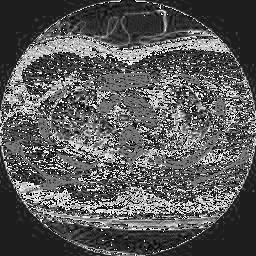

In [18]:
trans1(test_dataset[19][0][0][12])

In [16]:
for i in range(1000):
    if test_dataset[i][1].item():
        print(i)

13
61
65


KeyboardInterrupt: 

In [17]:
test_dataset[13][1]

tensor([1.])

In [18]:
#net = peNet(1)
#net.cuda()
im = test_dataset[13][0]
im2 = test_dataset[12][0]

In [19]:
im.size()

torch.Size([3, 24, 256, 256])

In [20]:
net.eval()
net(im.unsqueeze(0).cuda())

tensor([[-0.0203]], device='cuda:0', grad_fn=<AddmmBackward>)

In [21]:
net(im2.unsqueeze(0).cuda())

tensor([[-0.0409]], device='cuda:0', grad_fn=<AddmmBackward>)

In [12]:
class PE_det(torch.utils.data.Dataset):
    def __init__(self, Table, randomize = True, augment = True, window = 24):
        self.slices = list(Table['slice'].unique())
        self.window = window
        self.Table = Table
        self.augmented = augment
        if randomize:
            np.random.shuffle(self.slices)
    def __getitem__(self, index):
        mini_batch = self.Table[self.Table.slice == self.slices[index]].reset_index().drop(['index'], axis = 1)
        Study = mini_batch['StudyInstanceUID'][0]
        temp = self.Table[self.Table.StudyInstanceUID == Study]
        Input = form_batch(mini_batch, self.window, (256, 256), self.augmented)
        #Target = torch.zeros(2)
        Target = torch.zeros(1)
        pe_num = len(mini_batch[mini_batch.pe_present_on_image == 1])
        Target[0] = int(pe_num > (len(mini_batch) / 6))
        return([Input, Target])
    def __len__(self):
        return(len(self.slices))
def train_det(net, optimizer, train_loader, criterion, alpha = 2,  n_epoch = 2,
          train_acc_period = 5,
          test_acc_period = 5,
          cuda=True, visualize = True):
    loss_train = []
    loss_test = []
    total = 0
    if cuda:
        net = net.cuda()
        %env CUDA_LAUNCH_BLOCKING=1
    for epoch in tnrange(n_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        for i, (inputs, labels) in tqdm(enumerate(train_loader)):
            # get the inputs
            if cuda:
                net = net.cuda()
                inputs = inputs.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            outputs = outputs.clamp(min = 0, max = 1)
            predicted = (outputs>0.5).float()
            #print(labels, outputs)
            loss = criterion(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            # print statistics
            running_loss = 0.33*loss.item()/labels.size(0) + 0.66*running_loss
            TP = torch.logical_and((predicted == labels) , (labels == 1)).sum().item()
            FN = torch.logical_and((predicted != labels) , (labels == 0)).sum().item()
            TN = torch.logical_and((predicted == labels) , (labels == 0)).sum().item()
            FP = torch.logical_and((predicted != labels) , (labels == 1)).sum().item()
            precision = TP/(TP + FP + 0.0001)
            recall = TP/(TP + FN + 0.0001)
            #correct = 2*precision*recall/(precision + recall + 0.0001)
            correct = precision
            running_acc = 0.3*correct + 0.66*running_acc
            loss_train.append(running_loss)
            if visualize:
                if i % train_acc_period == train_acc_period-1:
                    print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
                    print('[%d, %5d] acc: %.3f' %(epoch + 1, i + 1, running_acc))
                    running_loss = 0.0
                    total = 0
            inputs = None
            outputs = None
            labels = None
            predicted = None
      
    if visualize:
        print('Finished Training')
    return(loss_train[-1])

def evaluate_det(net, test_loader):
    TP, TN, FP, FN = 0, 0, 0, 0
    net = net.cuda()
    for i, (inputs, labels) in tqdm(enumerate(test_loader)):
        inputs = inputs.type(torch.cuda.FloatTensor)
        labels = labels.type(torch.cuda.LongTensor)
        outputs = net(inputs)
        predicted = (outputs>0.5).float()
        #print(predicted == labels, labels)
        TP += torch.logical_and((predicted == labels) , (labels == 1)).sum().item()
        FN += torch.logical_and((predicted != labels) , (labels == 0)).sum().item()
        TN += torch.logical_and((predicted == labels) , (labels == 0)).sum().item()
        FP += torch.logical_and((predicted != labels) , (labels == 1)).sum().item()
        inputs = None
        labels = None
        predicted = None
    print('TP: ', TP, 'FP: ', FP, 'TN: ', TN, 'FN: ', FN)
    precision = TP/(TP + FP + 0.0001)
    recall = TP/(TP + FN + 0.0001)
    print('precision: ', precision, 'recall: ', recall)
    return(precision, recall, 2*precision*recall/(precision + recall + 0.0001))